# Autoencoder para reducción de ruido

El modelo es tomado de [GuitarsAI](https://github.com/GuitarsAI) https://www.youtube.com/watch?v=gVFCX-olr-M

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
from pydub import AudioSegment

In [2]:
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle

In [3]:
os.chdir("../Audios")
wd=os.getcwd()
wd_norm=os.listdir('Normal')
wd_sarc=os.listdir('Sarcasmo')

Aqui hay un problema, no esta leyendo el audio 35, ni 36, no sé si de ahí en adelante tampoco

In [4]:
for audio in wd_norm:
    # files                                                                         
    src = "Normal/"+audio
    dst = "Normal_wav/"+audio[:-3]+"wav"
    
    # convert wav to mp3    Audios/Normal/Audio_1.mp3                                                        
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.1 (GCC) 20200726
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt --enable-amf
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
[mp3 @ 000001b009c35400] Failed to read frame size: Could not seek to 11542.
Normal/Audio_35.mp3: Invalid argument


In [5]:
from IPython.display import Audio
display(Audio('Normal/Audio_35.mp3'))

Aquí tambien hay problemas, el audio 100 no lo está leyendo

In [6]:
for audio in wd_sarc:
    # files                                                                         
    src = "Sarcasmo/"+audio
    dst = "Sarcasmo_wav/"+audio[:-3]+"wav"
    
    # convert wav to mp3    Audios/Normal/Audio_1.mp3                                                        
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.1 (GCC) 20200726
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt --enable-amf
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
[mp3 @ 000001a070635300] Failed to read frame size: Could not seek to 5867.
Sarcasmo/Audio_100.mp3: Invalid argument


In [7]:
display(Audio('Sarcasmo/Audio_100.mp3'))

Con uno de los audios que si se pasaron a .wav mire algo del procesamiento de audios tomado de [Beginner's Guide to Audio Data](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data). Los siguientes gráficos son del audio crudo (1D array) 

In [16]:
display(Audio('Normal_wav/Audio_1.wav'))

In [11]:
# scipy
from scipy.io import wavfile
rate, data = wavfile.read("Normal_wav/Audio_1.wav")
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (281088, 2)
[[   0    0]
 [   0    0]
 [   0    0]
 ...
 [  -8   -8]
 [ -59  -59]
 [-114 -114]]


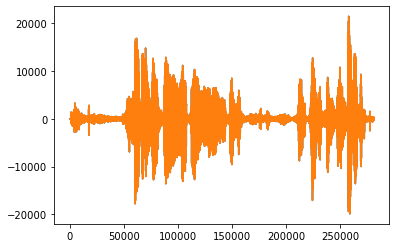

In [12]:
#Gráfico de los frames(marcos) del audio
plt.plot(data, '-', );

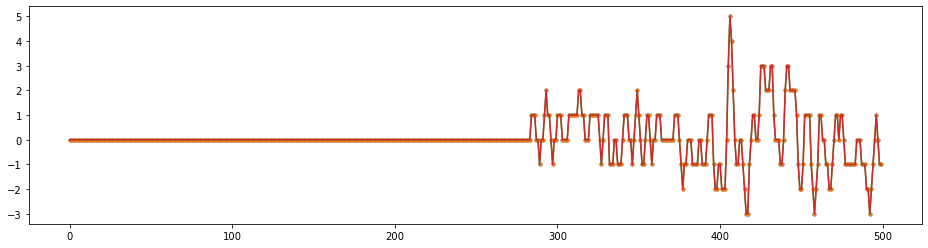

In [15]:
#Zoom en los primeros 1000 frames
plt.figure(figsize=(16, 4))
plt.plot(data[:1000], '.'); plt.plot(data[:1000], '-');

## Con audios en MP3
MFCC (Mel Frquency Cepstral Coefficients). MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics.

In [6]:
SAMPLE_RATE = 44100
wav, _ = librosa.core.load("Normal/Audio_1.mp3", sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [7]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 173)

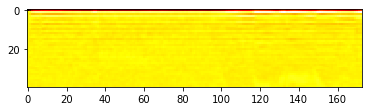

In [8]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');